In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout



In [2]:

# ==========================================
# 1. IMPORT MODULES & DATA LOADING
# ==========================================
print("Step 1: Loading Data...")
df = pd.read_csv('car_dataset.csv')

# ==========================================
# 2. DATA CLEANING
# ==========================================
print("Step 2: Data Cleaning...")
# Dropping redundant index and unit columns if they exist
df.drop(['Unnamed: 0', 'Mileage Unit'], axis=1, inplace=True, errors='ignore')

# Check for null values
print("Missing values count:\n", df.isnull().sum())


Step 1: Loading Data...
Step 2: Data Cleaning...
Missing values count:
 name                  0
year                  0
selling_price         0
km_driven             0
fuel                  0
seller_type           0
transmission          0
owner                 0
seats                 0
max_power (in bph)    0
Mileage               0
Engine (CC)           0
dtype: int64


Step 3: Performing EDA...


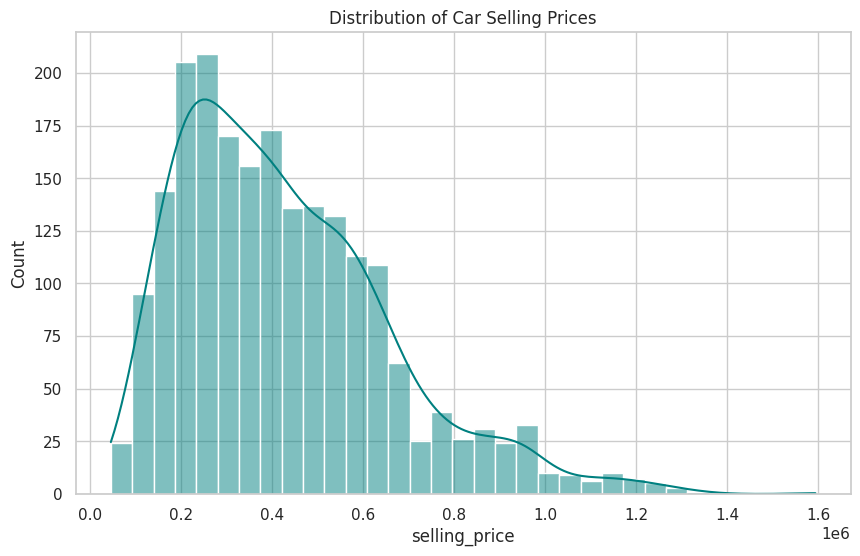

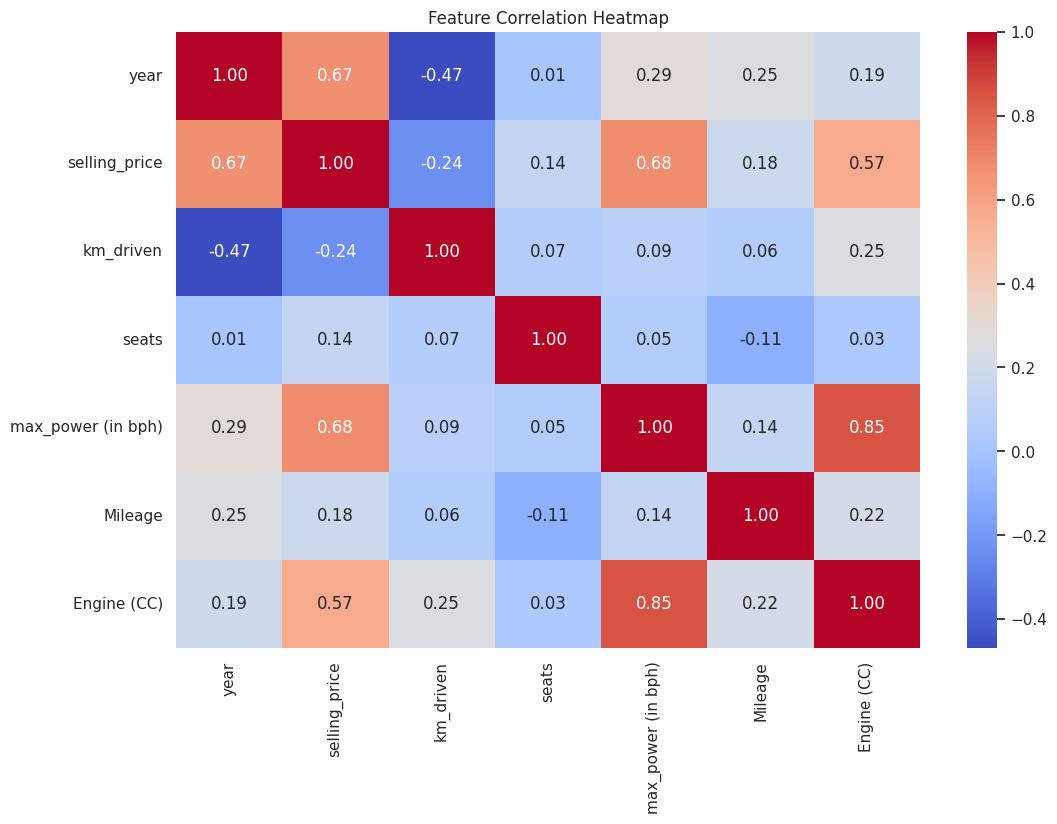

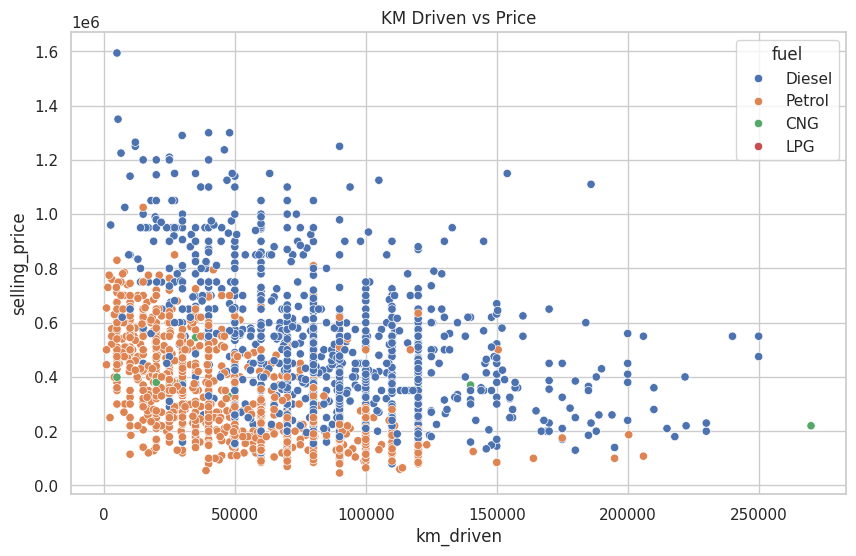

In [3]:

# ==========================================
# 3. EDA (Exploratory Data Analysis)
# ==========================================
print("Step 3: Performing EDA...")
sns.set(style="whitegrid")

# Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['selling_price'], kde=True, color='teal')
plt.title('Distribution of Car Selling Prices')
plt.savefig('eda_price_dist.png')

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.savefig('eda_correlation.png')

# KM Driven vs Selling Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='km_driven', y='selling_price', hue='fuel', data=df)
plt.title('KM Driven vs Price')
plt.savefig('eda_km_vs_price.png')


In [4]:

# ==========================================
# 4. DATA PREPROCESSING
# ==========================================
print("Step 4: Data Preprocessing...")
# Encode Categorical Variables
encoders = {}
categorical_cols = ['name', 'fuel', 'seller_type', 'transmission', 'owner']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# Define Features (X) and Target (y)
X = df.drop('selling_price', axis=1)
y = df['selling_price']

# ==========================================
# 5. DATA SPLITTING
# ==========================================
print("Step 5: Data Splitting...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling (Mandatory for Deep Learning)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Step 4: Data Preprocessing...
Step 5: Data Splitting...


In [5]:

# ==========================================
# 6. MODEL BUILDING & TRAINING
# ==========================================
# --- Machine Learning: Random Forest ---
print("Training Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# --- Deep Learning: ANN ---
print("Training Deep Learning ANN...")
dl_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1) # Linear output for regression
])

dl_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = dl_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)


Training Random Forest...
Training Deep Learning ANN...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:

# ==========================================
# 7. MODEL EVALUATION
# ==========================================
print("\n--- Evaluation Results ---")
y_pred_rf = rf_model.predict(X_test)
y_pred_dl = dl_model.predict(X_test_scaled).flatten()

def evaluate(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} -> R2: {r2:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    return r2

r2_rf = evaluate(y_test, y_pred_rf, "Random Forest")
r2_dl = evaluate(y_test, y_pred_dl, "Deep Learning")



--- Evaluation Results ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Random Forest -> R2: 0.8958, MAE: 47954.48, RMSE: 70167.63
Deep Learning -> R2: 0.8366, MAE: 64776.24, RMSE: 87898.37


/tmp/ipython-input-1068453499.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=scores, palette='viridis')


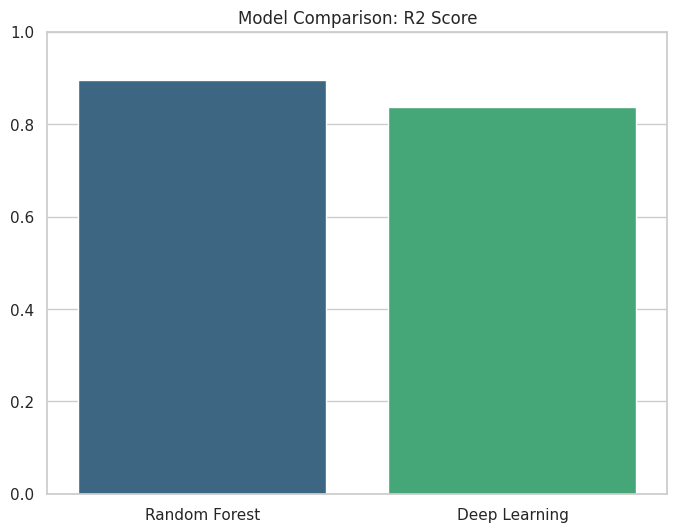

In [7]:

# ==========================================
# 8. COMPARISON GRAPHS
# ==========================================
plt.figure(figsize=(8, 6))
models = ['Random Forest', 'Deep Learning']
scores = [r2_rf, r2_dl]
sns.barplot(x=models, y=scores, palette='viridis')
plt.title('Model Comparison: R2 Score')
plt.ylim(0, 1)
plt.savefig('model_comparison.png')


In [8]:

# ==========================================
# 9. MODEL SAVING
# ==========================================
print("\nStep 9: Saving Models...")
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

dl_model.save('dl_model.h5')
print("All artifacts saved! (rf_model.pkl, dl_model.h5, scaler.pkl, encoders.pkl)")


Step 9: Saving Models...


All artifacts saved! (rf_model.pkl, dl_model.h5, scaler.pkl, encoders.pkl)
